<a href="https://colab.research.google.com/github/alima002/electron_density/blob/main/prop_H2_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pennylane
!pip install pyscf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.1/56.1 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 14.1 MB/s eta 0:00:00


#imports

In [25]:
import pennylane as qml
from pyscf import gto, scf, tools
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

#User informations

In [3]:
#modifications that must be made by the user
geom = """
 H 0.0  0.0 0.0
 H 0.74 0.0 0.0
"""
charge = 0
mult = 1
spin = 0
verbose=10
basis = "STO-3G"
Ang2Bohr = 1.8897259886

nelec = 2
active_space = False
active_electrons = None
active_orbitals = None

#Pyscf

In [4]:
#pyscf calculations
mol = gto.M(atom=geom, basis=basis, charge=charge, spin=spin, verbose=verbose)
wf = scf.HF(mol)
wf.kernel()

if isinstance(wf, scf.uhf.UHF):  # Path to UHF Class
    Ca, Cb = wf.mo_coeff  # UHF returns two arrays
else:
    Ca = wf.mo_coeff  # RHF or HF returns a single array
    Cb = Ca  # In RHF, the α and β orbitals are the same

S = mol.intor("int1e_ovlp")
I = Ca.T @ S @ Ca

System: uname_result(system='Linux', node='92f15901684a', release='6.1.85+', version='#1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024', machine='x86_64')  Threads 2
Python 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
numpy 1.26.4  scipy 1.13.1  h5py 3.12.1
Date: Sat Mar  1 20:15:58 2025
PySCF version 2.8.0
PySCF path  /usr/local/lib/python3.11/dist-packages/pyscf

[CONFIG] ARGPARSE = False
[CONFIG] DEBUG = False
[CONFIG] MAX_MEMORY = 4000
[CONFIG] TMPDIR = /tmp
[CONFIG] UNIT = angstrom
[CONFIG] VERBOSE = 3
[CONFIG] conf_file = None
[INPUT] verbose = 10
[INPUT] max_memory = 4000 
[INPUT] num. atoms = 2
[INPUT] num. electrons = 2
[INPUT] charge = 0
[INPUT] spin (= nelec alpha-beta = 2S) = 0
[INPUT] symmetry False subgroup None
[INPUT] Mole.unit = angstrom
[INPUT] Symbol           X                Y                Z      unit          X                Y                Z       unit  Magmom
[INPUT]  1 H      0.000000000000   0.000000000000   0.000000000000 AA    0.000000000000   0

In [5]:
#rdm1 in atomic orbitals, using pyscf
rdm1_pyscf = wf.make_rdm1()
print(rdm1_pyscf)


#If UHF or RHF is used, it is necessary to add the two generated matrices:
#rdm1_pyscf = np.sum(rdm1_pyscf, axis=0)
#print(rdm1_pyscf)
#print("Shape of rdm1_pyscf:", rdm1_pyscf.shape)

[[0.60245569 0.60245569]
 [0.60245569 0.60245569]]


In [6]:
#----------electron density with pyscf----------------
#grid
grid = np.linspace(-1.5, 1.5, 25).reshape(-1, 1)
grid = np.hstack([grid, np.zeros((grid.shape[0], 2))])
grid = np.array(grid) * Ang2Bohr

#GTOs calculations
ao_vals_pyscf = gto.eval_gto(mol, "GTOval", grid)

#electron density
density_grid_pyscf = np.einsum("pi,ij,pj->p", ao_vals_pyscf, rdm1_pyscf, ao_vals_pyscf)
print(density_grid_pyscf)

[0.00045    0.00079385 0.00141601 0.00256469 0.00469693 0.00858838
 0.01542735 0.02703016 0.04723037 0.08621566 0.16211185 0.27358555
 0.35502457 0.34305276 0.28361502 0.2564438  0.28795736 0.34697608
 0.35172226 0.26451309 0.15437057 0.08199044 0.04512067 0.02586097
 0.01473515]


#Pennylane

In [7]:
#Creating the matrix C from Ca and Cb obtained with pyscf
def C_2nd_quantization_order(Ca, Cb):
  N = Ca.shape[0]
  M = 2*Ca.shape[1]

  C = np.empty((N,M), dtype=Ca.dtype)

  C[:,0::2] = Ca
  C[:,1::2] = Cb

  return C

print(C_2nd_quantization_order(Ca,Cb))

[[ 0.54884228  0.54884228  1.21245192  1.21245192]
 [ 0.54884228  0.54884228 -1.21245192 -1.21245192]]


In [8]:
import numpy as np
import pennylane as qml

geom_data = geom.split()
symbols = tuple(geom_data[4*i] for i in range(len(geom_data)//4))
coordinates = tuple(geom_data[4*i+1:4*i+4] for i in range(len(geom_data)//4))
coordinates = np.array(coordinates, dtype=float).reshape((-1, 3)) * Ang2Bohr

# Set up the molecule object
if active_space:
    qml_mol = qml.qchem.Molecule(symbols, coordinates, charge=charge, basis_name=basis,
                                 active_electrons=active_electrons, active_orbitals=active_orbitals)
else:
    qml_mol = qml.qchem.Molecule(symbols, coordinates, charge=charge, basis_name=basis)
    # Assume that the number of qubits is sufficient to represent all electrons

# Calculate the Hamiltonian and the number of qubits
H, qubits = qml.qchem.molecular_hamiltonian(qml_mol)

if active_space:
    ref_on_vector = qml.qchem.hf_state(active_electrons, qubits)
else:
    ref_on_vector = qml.qchem.hf_state(nelec, qubits)


In [9]:
#Generating the JW transformation matrix

CREATION_FERMION_OP_TYPE = 0   #The creation operator 𝑎† is defined as (1/2)*(𝑋−𝑖𝑌).
ANNIHILATION_FERMION_OP_TYPE = 1  #The annihilation operator 𝑎 is defined as (1/2)*(𝑋+𝑖𝑌).


def pauli_string_fermion_operator(p, op_type):
  f = (2*op_type-1)*1j    # When op_type = 0 (creation), f = -i, else f = i

  Q_p = 0.5*(qml.PauliX(p) + f * qml.PauliY(p))  #linear combination of the Pauli operators X and Y, with the correct factor to represent the fermion operators

  if p == 0:
    return Q_p

  for i in range(p):
    Q_p = qml.PauliZ(i) @ Q_p  # Adds Z operators to preserve fermionic anticommutation rules.

  return Q_p


def pauli_string_excitation_operator(p, q):
  a_dagger_p = pauli_string_fermion_operator(p, CREATION_FERMION_OP_TYPE)
  a_q = pauli_string_fermion_operator(q, ANNIHILATION_FERMION_OP_TYPE)
  return a_dagger_p @ a_q


In [10]:
dev = qml.device("default.qubit", wires=qubits)

#Circuit with only the reference state

@qml.qnode(dev)
def excitation_operator_expval(ref_on_vector, X_pq):
  qml.BasisState(ref_on_vector, wires=range(qubits))
  return qml.expval(X_pq)

#If we have the parameters of a given circuit we can use it. Here is an example for GateFabric
#loaded_params = np.load("final_params.npy")
#expected_shape = qml.GateFabric.shape(n_layers=1, n_wires=qubits)
#@qml.qnode(dev)
#def circuit():
#    qml.GateFabric(loaded_params, wires=range(qubits), init_state=ref_occ, include_pi=True)
#    return qml.expval(X_pq)


In [11]:
#Constructing the reduced density matrix using the output of the pennylane circuit with the excitation operator Xp

def build_rdm1(qubits):
  # D_pq = <psi|X_qp|psi> = <psi|a_dagger_q*a_p|psi>
  Xs = (pauli_string_excitation_operator(q, p) for p in range(qubits) for q in range(qubits))
  rdm1 = tuple(excitation_operator_expval(ref_on_vector, X_qp) for X_qp in Xs)
  return np.array(rdm1).reshape((qubits,qubits))

#rdm1 in molecular orbitals

def rdm1_mo2ao(rdm1, C):
  return C @ rdm1 @ C.T

#rdm1 in atomic orbitals
def build_rdm1_ao(qubits, C):
  rdm1 = build_rdm1(qubits)
  return rdm1_mo2ao(rdm1, C)

#electron density with pennylane
def compute_electron_density_grid(rdm1, ao_vals):
  return np.einsum("ip,pq,iq->i", ao_vals, rdm1, ao_vals)

In [12]:
C = C_2nd_quantization_order(Ca,Cb) # MO coeff. matrix
rdm1 = build_rdm1(qubits) # in MO basis
print('rdm1 in molecular orbitals')
print(rdm1)
rdm1_ao = rdm1_mo2ao(rdm1, C) # convert to AO basis

print('rdm1 in atomic orbitals')
print(rdm1_ao)

rdm1 in molecular orbitals
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
rdm1 in atomic orbitals
[[0.60245569 0.60245569]
 [0.60245569 0.60245569]]


/usr/local/lib/python3.11/dist-packages/autoray/autoray.py:1127: ComplexWarning: Casting complex values to real discards the imaginary part
  return x.astype(dtype, **kwargs)


In [13]:
density_grid = compute_electron_density_grid(rdm1_ao, ao_vals_pyscf)
print(density_grid)

[0.00045    0.00079385 0.00141601 0.00256469 0.00469693 0.00858838
 0.01542735 0.02703016 0.04723037 0.08621566 0.16211185 0.27358555
 0.35502457 0.34305276 0.28361502 0.2564438  0.28795736 0.34697608
 0.35172226 0.26451309 0.15437057 0.08199044 0.04512067 0.02586097
 0.01473515]


#Electron density

In [14]:
print('pyscf')
print(rdm1_pyscf)

print('pennylane')
print(rdm1_ao)

pyscf
[[0.60245569 0.60245569]
 [0.60245569 0.60245569]]
pennylane
[[0.60245569 0.60245569]
 [0.60245569 0.60245569]]


In [15]:
#Differences between electron density with pyscf and pennylane
difference = density_grid - density_grid_pyscf
print(difference)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0.]


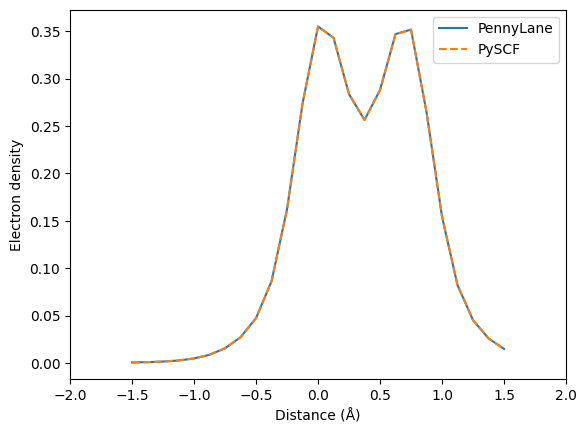

<ipython-input-85-345c4e28ed56>:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


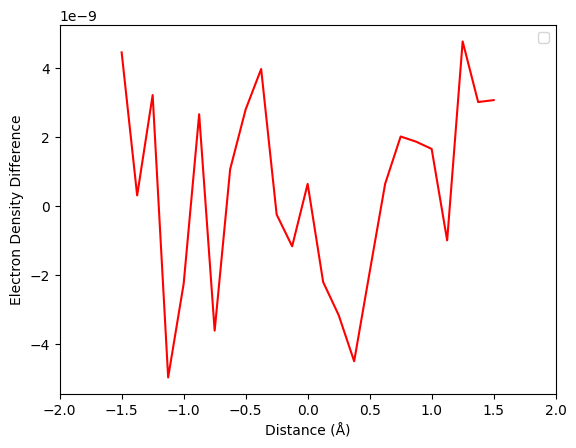

In [85]:
import matplotlib.pyplot as plt

plt.plot(grid[:, 0] / Ang2Bohr, density_grid, label="PennyLane")
plt.plot(grid[:, 0] / Ang2Bohr, density_grid_pyscf, label="PySCF", linestyle="dashed")
plt.xlim(-2, 2)

plt.xlabel("Distance (Å)")
plt.ylabel("Electron density")
plt.legend()
plt.show()

plt.plot(grid[:, 0] / Ang2Bohr, density_grid - density_grid_pyscf, color='red')
plt.xlim(-2, 2)

plt.xlabel("Distance (Å)")
plt.ylabel("Electron Density Difference")
plt.legend()
plt.show()


##Maximum and Minimum values
Bond-critical points (BCP) Is the minimun value

In [89]:
def laplacian_1d(f, dx):
    """
    Compute the 1D Laplacian of a function using finite differences.

    Parameters:
    f (array-like): The function values (density values in your case).
    dx (float): The spacing between points in the 1D grid.

    Returns:
    array-like: The Laplacian of the function.
    """
    laplacian = (f[2:] - 2 * f[1:-1] + f[:-2]) / (dx**2)
    return laplacian


#----------------- PySCF ---------------------------------------------------------


# Ensure that x has the same size as the density
x_pyscf = np.linspace(-2, 2, len(density_grid_pyscf))

# Calculate the Laplacian of the electron density for PySCF
dx = x_pyscf[1] - x_pyscf[0]  # Considering the spacing between the x points
laplacian_pyscf = laplacian_1d(density_grid_pyscf, dx)

# Calculate the first and second derivatives using np.gradient
drho_dx_pyscf = np.gradient(density_grid_pyscf, x_pyscf)
d2rho_dx2_pyscf = np.gradient(drho_dx_pyscf, x_pyscf)

# Find local maxima and minima
maxima_pyscf = argrelextrema(density_grid_pyscf, np.greater)[0]
minima_pyscf = argrelextrema(density_grid_pyscf, np.less)[0]

#----------------- PennyLane -----------------------------------------------------

# Ensure that x has the same size as the density
x_pennylane = np.linspace(-2, 2, len(density_grid))

# Calculate the Laplacian of the electron density for PennyLane
dx_pennylane = x_pennylane[1] - x_pennylane[0]  # Considering the spacing between the x points
laplacian_pennylane = laplacian_1d(density_grid, dx_pennylane)

# Calculate the first and second derivatives using np.gradient
drho_dx_pennylane = np.gradient(density_grid, x_pennylane)
d2rho_dx2_pennylane = np.gradient(drho_dx_pennylane, x_pennylane)

# Find local maxima and minima
maxima_pennylane = argrelextrema(density_grid, np.greater)[0]
minima_pennylane = argrelextrema(density_grid, np.less)[0]


#----------------- Prints --------------------------------------

def print_critical_points(label, x_values, density_values):
    for idx in x_values:
        print(f"{label} at x = {x_pyscf[idx]:.3f} Å with density {density_values[idx]:.3f}")

# Print the critical points
print("PySCF Critical Points:")
print_critical_points("Local maximum", maxima_pyscf, density_grid_pyscf)
print_critical_points("Local minimum", minima_pyscf, density_grid_pyscf)

print("\nPennyLane Critical Points:")
print_critical_points("Local maximum", maxima_pennylane, density_grid)
print_critical_points("Local minimum", minima_pennylane, density_grid)


PySCF Critical Points:
Local maximum at x = 0.000 Å with density 0.355
Local maximum at x = 1.000 Å with density 0.352
Local minimum at x = 0.500 Å with density 0.256

PennyLane Critical Points:
Local maximum at x = 0.000 Å with density 0.355
Local maximum at x = 1.000 Å with density 0.352
Local minimum at x = 0.500 Å with density 0.256


Laplacian of a 1D (density) function using the finite difference formula:




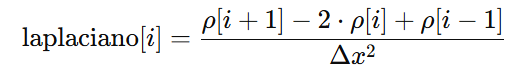

In [81]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

# Function to calculate the Laplacian (second derivative)
def laplacian_1d(rho_data, dx):
    laplacian_data = np.zeros_like(rho_data)

    # Calculate the second derivative in 1D using finite differences
    for i in range(1, len(rho_data) - 1):  # Evita as bordas
        laplacian_data[i] = (rho_data[i+1] - 2 * rho_data[i] + rho_data[i-1]) / dx**2

    return laplacian_data

#----------------- PySCF ---------------------------------------------------------
# Ensures that x has the same size as the density
x_pyscf = np.linspace(-2, 2, len(density_grid_pyscf))
# Calculate the electron density laplacian for PySCF
dx = x_pyscf[1] - x_pyscf[0]  # Considering the spacing between the points of x
laplacian_pyscf = laplacian_1d(density_grid_pyscf, dx)

# Find local maxima and minima
maxima_pyscf = argrelextrema(density_grid_pyscf, np.greater)[0]
minima_pyscf = argrelextrema(density_grid_pyscf, np.less)[0]

#----------------- PennyLane -----------------------------------------------------


x_pennylane = np.linspace(-2, 2, len(density_grid))

dx_pennylane = x_pennylane[1] - x_pennylane[0]
laplacian_pennylane = laplacian_1d(density_grid, dx_pennylane)
maxima_pennylane = argrelextrema(density_grid, np.greater)[0]
minima_pennylane = argrelextrema(density_grid, np.less)[0]

#----------------- Printing the Laplacian at Critical Points -------------------

print("\nLaplacian at Critical Points for PySCF Electron Density:")


#-----------------Pyscf---------------------------------------------------------
print("\nPySCF Local Maxima Laplacian:")
for i in maxima_pyscf:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pyscf[i]:.5f}")

print("\nPySCF Local Minima Laplacian:")
for i in minima_pyscf:
    print(f"x = {x_pyscf[i]:.3f} Å: Laplacian = {laplacian_pyscf[i]:5f}")

print("\nLaplacian at Critical Points for PennyLane Electron Density:")

#----------------- Differences between Laplacians and Δρ at Critical Points ------------------

print("\nDifferences between PySCF and PennyLane Laplacian at Critical Points:")

# Differences in local maxima
print("\nDifferences at Local Maxima:")
for i, max_pyscf in enumerate(maxima_pyscf):
    if i < len(maxima_pennylane):
        x_diff = abs(x_pyscf[max_pyscf] - x_pennylane[maxima_pennylane[i]])
        laplacian_diff = abs(laplacian_pyscf[max_pyscf] - laplacian_pennylane[maxima_pennylane[i]])
        rho_diff = abs(density_grid_pyscf[max_pyscf] - density_grid[maxima_pennylane[i]])
        print(f"Max Diff at x = {x_pyscf[max_pyscf]:.5f} Å: Δx = {x_diff:.5f} Å, ΔLaplacian = {laplacian_diff:.5f}, Δρ = {rho_diff:.5f}")

# Differences in local minima
print("\nDifferences at Local Minima:")
for i, min_pyscf in enumerate(minima_pyscf):
    if i < len(minima_pennylane):
        x_diff = abs(x_pyscf[min_pyscf] - x_pennylane[minima_pennylane[i]])
        laplacian_diff = abs(laplacian_pyscf[min_pyscf] - laplacian_pennylane[minima_pennylane[i]])
        rho_diff = abs(density_grid_pyscf[min_pyscf] - density_grid[minima_pennylane[i]])
        print(f"Min Diff at x = {x_pyscf[min_pyscf]:.5f} Å: Δx = {x_diff:.5f} Å, ΔLaplacian = {laplacian_diff:.5f}, Δρ = {rho_diff:.5f}")


Laplacian at Critical Points for PySCF Electron Density:

PySCF Local Maxima Laplacian:
x = 0.000 Å: Laplacian = -3.36279
x = 1.000 Å: Laplacian = -3.31039

PySCF Local Minima Laplacian:
x = 0.500 Å: Laplacian = 2.112652

Laplacian at Critical Points for PennyLane Electron Density:

Differences between PySCF and PennyLane Laplacian at Critical Points:

Differences at Local Maxima:
Max Diff at x = 0.00000 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00000, Δρ = 0.00000
Max Diff at x = 1.00000 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00000, Δρ = 0.00000

Differences at Local Minima:
Min Diff at x = 0.50000 Å: Δx = 0.00000 Å, ΔLaplacian = 0.00000, Δρ = 0.00000


#Dipole moment

In [17]:
from pyscf.scf.hf import dip_moment

print('Pyscf')
dipole_moment_pyscf = dip_moment(mol, rdm1_pyscf)

print('Pennylane')
dipole_moment_pennylane = dip_moment(mol, rdm1_ao)

print('diferrence: pennylane - pyscf')
difference_dipole = dipole_moment_pennylane - dipole_moment_pyscf
print(difference_dipole)

Pyscf
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000,  0.00000
Pennylane
Dipole moment(X, Y, Z, Debye):  0.00000,  0.00000,  0.00000
diferrence: pennylane - pyscf
[0. 0. 0.]


#Mulliken pop

In [18]:
from pyscf.scf.hf import mulliken_pop

print('Pyscf')
mulliken_pop_pyscf = mulliken_pop(mol, rdm1_pyscf)

print('Pennylane')
mulliken_pop_pennylane = mulliken_pop(mol, rdm1_ao)

Pyscf
 ** Mulliken pop  **
pop of  0 H 1s            1.00000
pop of  1 H 1s            1.00000
 ** Mulliken atomic charges  **
charge of    0H =     -0.00000
charge of    1H =      0.00000
Pennylane
 ** Mulliken pop  **
pop of  0 H 1s            1.00000
pop of  1 H 1s            1.00000
 ** Mulliken atomic charges  **
charge of    0H =     -0.00000
charge of    1H =      0.00000


In [19]:
# The atomic charges are in the second part of the output tuple
charges_pyscf = mulliken_pop_pyscf[1]
charges_pennylane = mulliken_pop_pennylane[1]

# Calculate the difference between atomic charges
charge_differences = np.array(charges_pyscf) - np.array(charges_pennylane)

print("\nDifference between atomic charges:")
for i, diff in enumerate(charge_differences):
    print(f"Ato {i}: Diferença de carga = {diff:.6f}")


Difference between atomic charges:
Ato 0: Diferença de carga = 0.000000
Ato 1: Diferença de carga = 0.000000


#Electrostatic potential

In [21]:
def read_cube(filename):
    with open(filename, "r") as f:
        lines = f.readlines()

    # Skip the first 6 headers of the Cube file
    natoms = int(lines[2].split()[0])
    origin = np.array([float(x) for x in lines[2].split()[1:]])

    # Read grid dimensions
    nx, ny, nz = [int(lines[i].split()[0]) for i in range(3, 6)]
    grid_vectors = np.array([[float(x) for x in lines[i].split()[1:]] for i in range(3, 6)])

    # Calculate the coordinate grid
    x_vals = np.linspace(origin[0], origin[0] + grid_vectors[0, 0] * (nx - 1), nx)
    y_vals = np.linspace(origin[1], origin[1] + grid_vectors[1, 1] * (ny - 1), ny)
    z_vals = np.linspace(origin[2], origin[2] + grid_vectors[2, 2] * (nz - 1), nz)

    # Read electrostatic potential data
    data_start = 6 + natoms  # Skip the atom lines
    values = np.array([float(v) for line in lines[data_start:] for v in line.split()])

    # Resize to 3D grid
    data = values.reshape((nx, ny, nz))

    return x_vals, y_vals, z_vals, data


In [27]:
cube_pyscf = tools.cubegen.mep(mol, "mep_pyscf.cube", rdm1_pyscf, resolution=0.1)
cube_pennylane = tools.cubegen.mep(mol, "mep_pennylane.cube", rdm1_ao, resolution=0.1)

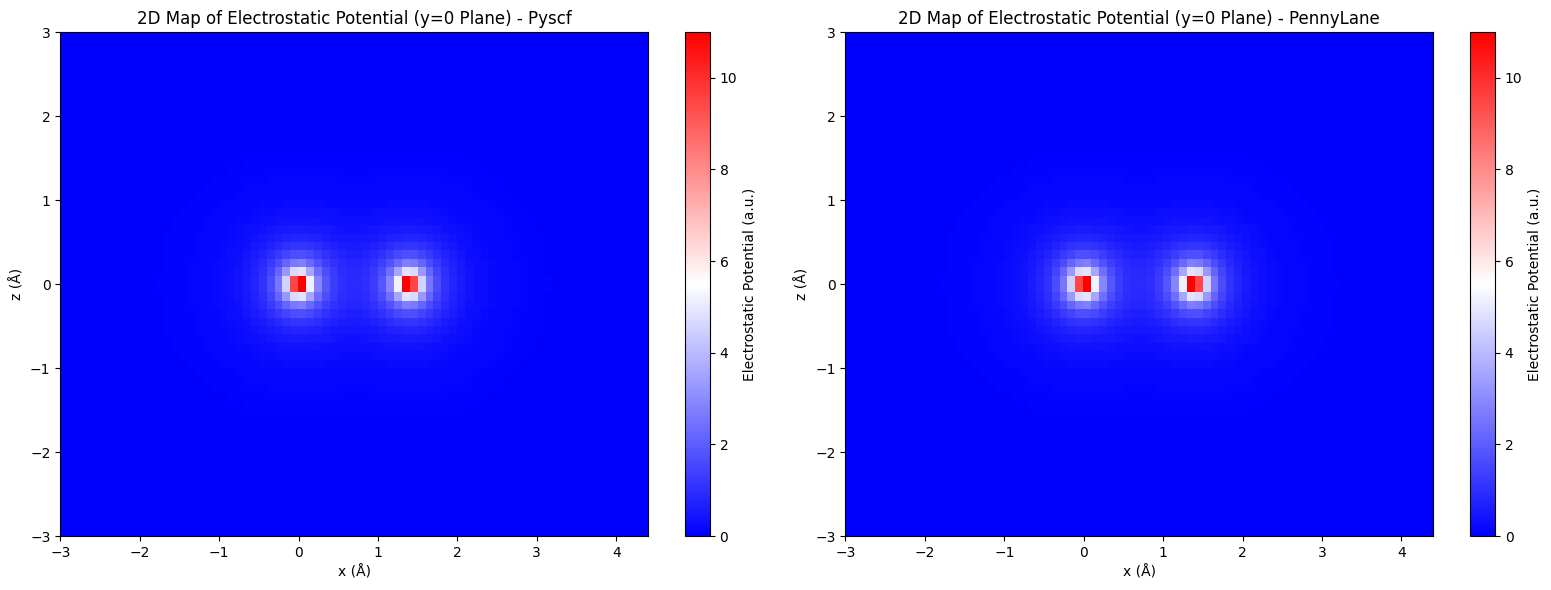

In [32]:
# Read data from the Cube file (Pyscf)
x_vals_1, y_vals_1, z_vals_1, data_1 = read_cube("mep_pyscf.cube")

# Take a cut in the middle of the grid (y plane = 0) for Pyscf
mid_y_1 = len(y_vals_1) // 2  # Central index
mep_2d_1 = data_1[:, mid_y_1, :]  # Grid slicing

# Read data from the Cube file (PennyLane)
x_vals_2, y_vals_2, z_vals_2, data_2 = read_cube("mep_pennylane.cube")

# Take a cut in the middle of the grid (y plane = 0) for PennyLane
mid_y_2 = len(y_vals_2) // 2  # Central index
mep_2d_2 = data_2[:, mid_y_2, :]  # Grid slicing

# Plotting the two heatmaps side by side
plt.figure(figsize=(16, 6))

# Subplot for Pyscf
plt.subplot(1, 2, 1)
plt.imshow(mep_2d_1.T, extent=[x_vals_1.min(), x_vals_1.max(), z_vals_1.min(), z_vals_1.max()],
           origin="lower", cmap="bwr", aspect="auto")
plt.colorbar(label="Electrostatic Potential (a.u.)")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("2D Map of Electrostatic Potential (y=0 Plane) - Pyscf")

# Subplot for PennyLane
plt.subplot(1, 2, 2)
plt.imshow(mep_2d_2.T, extent=[x_vals_2.min(), x_vals_2.max(), z_vals_2.min(), z_vals_2.max()],
           origin="lower", cmap="bwr", aspect="auto")
plt.colorbar(label="Electrostatic Potential (a.u.)")
plt.xlabel("x (Å)")
plt.ylabel("z (Å)")
plt.title("2D Map of Electrostatic Potential (y=0 Plane) - PennyLane")

plt.tight_layout()
plt.show()


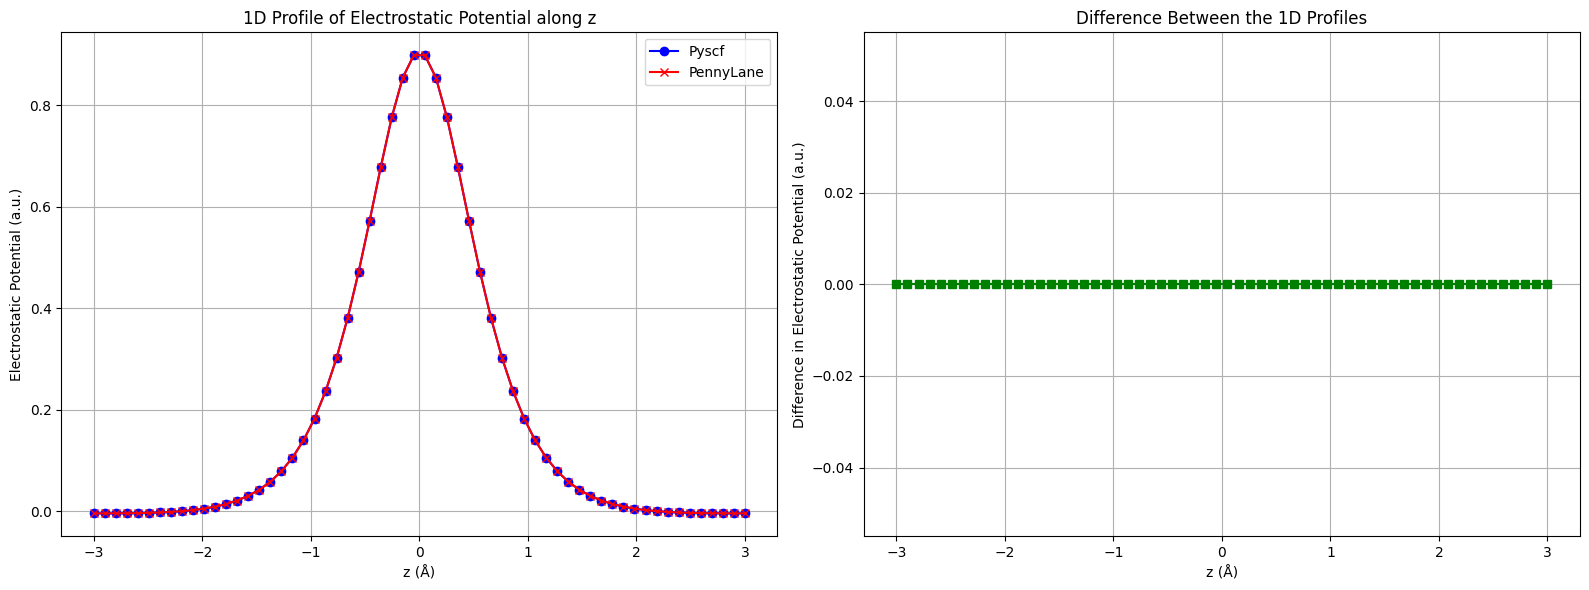

In [37]:
# Read data from the Cube file (Pyscf)
x_vals_1, y_vals_1, z_vals_1, data_1 = read_cube("mep_pyscf.cube")

# Extracting the 1D profile along the z-axis for Pyscf
ix_1 = len(x_vals_1) // 2
iy_1 = len(y_vals_1) // 2
mep_1d_1 = data_1[ix_1, iy_1, :]

# Read data from the Cube file (PennyLane)
x_vals_2, y_vals_2, z_vals_2, data_2 = read_cube("mep_pennylane.cube")

# Extracting the 1D profile along the z-axis for PennyLane
ix_2 = len(x_vals_2) // 2
iy_2 = len(y_vals_2) // 2
mep_1d_2 = data_2[ix_2, iy_2, :]

# Calculate the difference between the two profiles
mep_diff = mep_1d_1 - mep_1d_2

# Plotting the two profiles and their difference side by side
plt.figure(figsize=(16, 6))

# Subplot for the 1D profiles
plt.subplot(1, 2, 1)
plt.plot(z_vals_1, mep_1d_1, marker="o", label="Pyscf", color="b")
plt.plot(z_vals_2, mep_1d_2, marker="x", label="PennyLane", color="r")
plt.xlabel("z (Å)")
plt.ylabel("Electrostatic Potential (a.u.)")
plt.title("1D Profile of Electrostatic Potential along z")
plt.grid()
plt.legend()

# Subplot for the difference between the profiles
plt.subplot(1, 2, 2)
plt.plot(z_vals_1, mep_diff, marker="s", color="g")
plt.xlabel("z (Å)")
plt.ylabel("Difference in Electrostatic Potential (a.u.)")
plt.title("Difference Between the 1D Profiles")
plt.grid()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()
